# Mitigación de sesgo en el modelo original

## Índice de Contenido

1. [Preparación del entorno y carga de datos](#1.-Preparación-del-entorno-y-carga-de-datos)
2. [Primer método de mitigación](#2.-Primer-método-de-mitigación)
    - [Aplicación del método y entrenamiento del modelo](#2.1-Aplicación-del-método-y-entrenamiento-del-modelo)
    - [Evaluación del modelo mediante métricas de clasificación](#2.2-Evaluación-del-modelo-mediante-métricas-de-clasificación)
3. [Segundo método de mitigación](#3.-Segundo-método-de-mitigación)
    - [Aplicación del método y entrenamiento del modelo](#3.1-Aplicación-del-método-y-entrenamiento-del-modelo)
    - [Evaluación del modelo mediante métricas de clasificación](#3.2-Evaluación-del-modelo-mediante-métricas-de-clasificación)
4. [Evaluación de equidad de modelos mitigados](#4.-Evaluación-de-equidad-de-modelos-mitigados)
5. [Resumen y conclusiones](#5.-Resumen-y-conclusiones)

# 1. Preparación del entorno y carga de datos

In [58]:
import pandas as pd
import os 
from holisticai.bias.metrics import classification_bias_metrics
from sklearn.linear_model import LogisticRegression
from holisticai.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tp_final_fairness_ML.utils.plotting import graficar_matriz_de_confusion

# Carga de datos
ruta_X_train = os.path.join('..', 'data', 'processed', 'X_train.csv')
ruta_X_test = os.path.join('..', 'data', 'processed', 'X_test.csv')
ruta_y_train = os.path.join('..', 'data', 'processed', 'y_train.csv')
ruta_y_test = os.path.join('..', 'data', 'processed', 'y_test.csv')

X_train = pd.read_csv(ruta_X_train, index_col=0)
X_test = pd.read_csv(ruta_X_test, index_col=0)
y_train = pd.read_csv(ruta_y_train).values.ravel()
y_test = pd.read_csv(ruta_y_test).values.ravel()

# 2. Primer método de mitigación

## 2.1 Aplicación del método y entrenamiento del modelo

In [59]:
from holisticai.bias.mitigation import CorrelationRemover 

mitigator = CorrelationRemover()

metrics = {}

model = LogisticRegression(random_state=42, max_iter=1000)

pipeline = Pipeline(steps=[
                     ('scaler', StandardScaler()),
                     ("bm_preprocessing", mitigator), 
                     ("estimator", model),
                     ])

pipeline.fit(X_train, y_train, bm__group_a=X_train['genre_male'] == 1, bm__group_b=X_train['genre_male'] == 0)

y_pred_pipeline = pipeline.predict(X_test, bm__group_a=X_test['genre_male'] == 1, bm__group_b=X_test['genre_male'] == 0)

metrics_preprocessing_correlationRemover = classification_bias_metrics(
    X_test['genre_male']==1, 
    X_test['genre_male']==0, 
    y_pred_pipeline, 
    y_test, 
    metric_type='both')

metrics['CorrelationRemover'] = metrics_preprocessing_correlationRemover
print(metrics_preprocessing_correlationRemover)

                                       Value  Reference
Metric                                                 
Statistical Parity                 -0.097222          0
Disparate Impact                    0.888889          1
Four Fifths Rule                    0.888889          1
Cohen D                            -0.246777          0
2SD Rule                           -1.558155          0
Equality of Opportunity Difference -0.056561          0
False Positive Rate Difference     -0.205882          0
Average Odds Difference            -0.131222          0
Accuracy Difference                 0.027778          0


## 2.2 Evaluación del modelo mediante métricas de clasificación

In [60]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_pipeline))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.67      0.44      0.53        59
           1       0.80      0.91      0.85       141

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.69       200
weighted avg       0.76      0.77      0.75       200



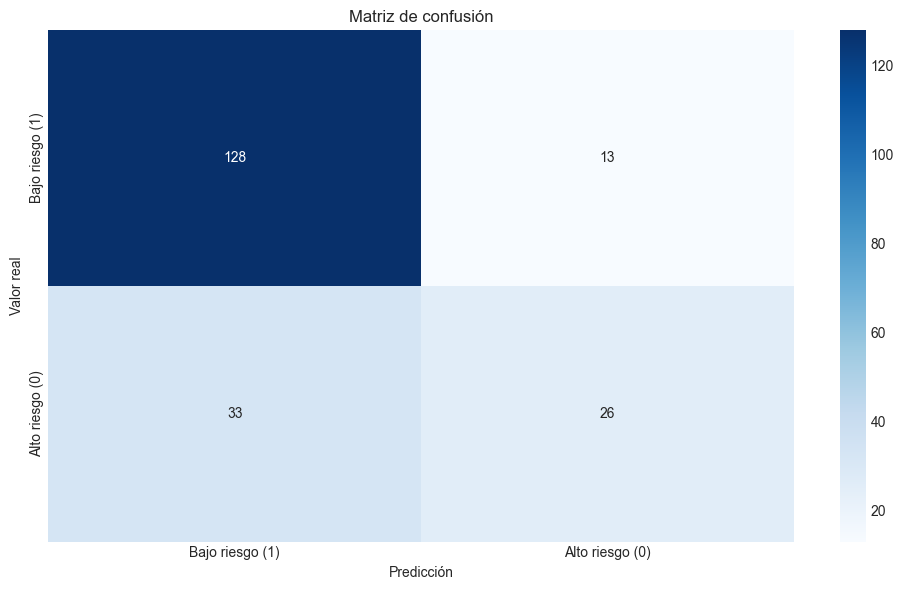

In [61]:
graficar_matriz_de_confusion(y_test, y_pred_pipeline)

# 3. Segundo método de mitigación

## 3.1 Aplicación del método y entrenamiento del modelo

In [62]:
from holisticai.bias.mitigation import PrejudiceRemover

mitigator = PrejudiceRemover(maxiter=100, fit_intercept=True, verbose=1, print_interval=1)

model = LogisticRegression(random_state=42, max_iter=1000)

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ("bm_inprocessing", mitigator.transform_estimator(model)),
])

pipeline.fit(X_train, y_train, bm__group_a=X_train['genre_male'] == 1, bm__group_b=X_train['genre_male'] == 0)

y_pred_prejudice = pipeline.predict(X_test, bm__group_a=X_test['genre_male'] == 1, bm__group_b=X_test['genre_male'] == 0)

metrics_prejudice = classification_bias_metrics(
    X_test['genre_male'] == 1,
    X_test['genre_male'] == 0,
    y_pred_prejudice,
    y_test,
    metric_type='both'
)

metrics['PrejudiceRemover'] = metrics_prejudice
print(metrics_prejudice)

[elapsed time: 00:00:00 | iter:5/100 | loss:400.8517]
[elapsed time: 00:00:00 | Best Loss : 400.8517]
                                       Value  Reference
Metric                                                 
Statistical Parity                 -0.058532          0
Disparate Impact                    0.931713          1
Four Fifths Rule                    0.931713          1
Cohen D                            -0.151043          0
2SD Rule                           -0.957166          0
Equality of Opportunity Difference -0.062594          0
False Positive Rate Difference     -0.064426          0
Average Odds Difference            -0.063510          0
Accuracy Difference                -0.018849          0


## 3.2 Evaluación del modelo mediante métricas de clasificación

In [63]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_prejudice))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.46      0.56        59
           1       0.80      0.93      0.86       141

    accuracy                           0.79       200
   macro avg       0.77      0.69      0.71       200
weighted avg       0.78      0.79      0.77       200



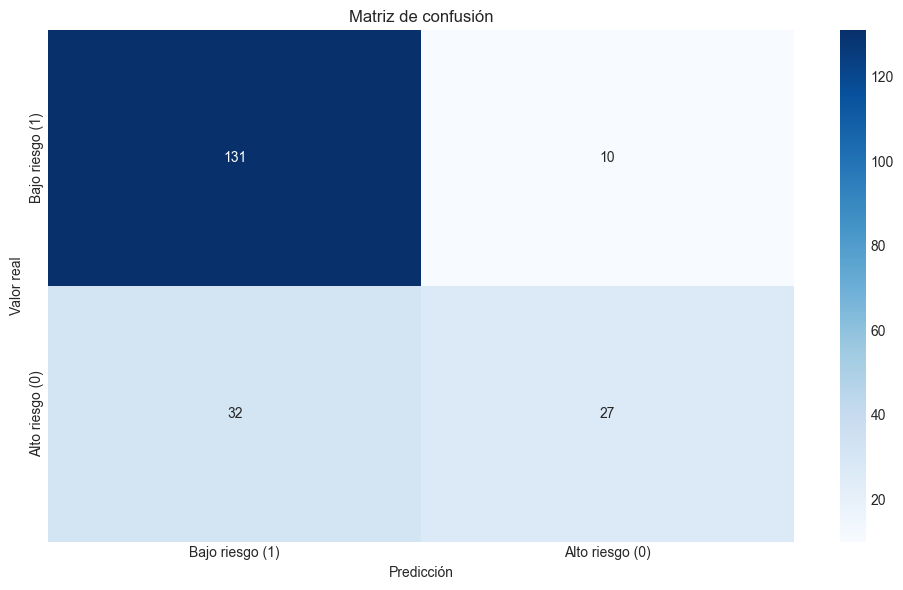

In [64]:
graficar_matriz_de_confusion(y_test, y_pred_prejudice)

# 4. Evaluación de equidad de modelos mitigados

In [65]:
keys = ['CorrelationRemover', 'PrejudiceRemover', 'Reference']
comparison = pd.concat([metrics_preprocessing_correlationRemover['Value'], metrics_prejudice], axis=1)
comparison.columns = keys

def highlight_closest(s):
    reference = s['Reference']
    differences = s.drop('Reference').apply(lambda x: abs(x - reference))
    closest = differences.idxmin()
    return ['background-color: mediumseagreen' if x == s[closest] else '' for x in s]

comparison_highlighted = comparison.style.apply(highlight_closest, axis=1)
comparison_highlighted

,CorrelationRemover,PrejudiceRemover,Reference
Metric,,,
Statistical Parity,-0.097222,-0.058532,0
Disparate Impact,0.888889,0.931713,1
Four Fifths Rule,0.888889,0.931713,1
Cohen D,-0.246777,-0.151043,0
2SD Rule,-1.558155,-0.957166,0
Equality of Opportunity Difference,-0.056561,-0.062594,0
False Positive Rate Difference,-0.205882,-0.064426,0
Average Odds Difference,-0.131222,-0.063510,0
Accuracy Difference,0.027778,-0.018849,0


# 5. Resumen y conclusiones

En este notebook hemos realizado las siguientes tareas:

1. **Preparación del entorno y carga de datos**: Se importaron los datos procesados de German Credit, ya preparados para el análisis y modelado.

2. **Aplicación de métodos de mitigación de sesgo**: Se implementaron dos enfoques para mitigar el sesgo de género en el modelo:
    - **CorrelationRemover** (preprocesamiento): Elimina la correlación entre las variables de entrada y el atributo protegido antes del entrenamiento.
    - **PrejudiceRemover** (in-processing): Incorpora una penalización durante el entrenamiento para reducir el sesgo en el modelo.

3. **Entrenamiento y evaluación de modelos mitigados**: Se entrenó un modelo de regresión logística bajo ambos métodos y se evaluó su desempeño mediante métricas de clasificación y fairness.

4. **Análisis de métricas de equidad**: Se compararon métricas como Statistical Parity, Disparate Impact, Four Fifths Rule, Cohen D, y otras, respecto a un valor de referencia ideal.

**Conclusiones:**

- Ambos métodos de mitigación lograron reducir el sesgo respecto al modelo base, acercando las métricas de fairness a los valores ideales.
- El método **PrejudiceRemover** mostró una mejora más consistente en la mayoría de las métricas de equidad, logrando valores más cercanos al punto de referencia en Statistical Parity, Disparate Impact y Average Odds Difference.
- El desempeño general del modelo mitigado se mantiene adecuado, con una exactitud del 77%. Sin embargo, persiste una diferencia en la sensibilidad para las clases: el modelo identifica mejor a los solicitantes de bajo riesgo (sensibilidad alta) que a los de alto riesgo.
- La mitigación del sesgo es posible sin sacrificar significativamente el desempeño global del modelo, aunque se recomienda seguir explorando técnicas y ajustando hiperparámetros para lograr un balance óptimo entre equidad y precisión.